In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from fastai.tabular import *
from fastai.callbacks import SaveModelCallback
from fastai.basic_data import DataBunch

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
TYPES              = np.array(['1JHC', '2JHH', '1JHN', '2JHN', '2JHC', '3JHH', '3JHC', '3JHN'])
TYPES_MAP          = {t: i for i, t in enumerate(TYPES)}
SC_EDGE_FEATS      = ['type_0', 'type_1', 'type_2', 'type_3', 'type_4', 'type_5', 'type_6', 'type_7', 'dist',
                      'dist_min_rad', 'dist_electro_neg_adj', 'normed_dist', 'diangle', 'cos_angle', 
                      'cos_angle0', 'cos_angle1']
MOL_FEATS          = ['num_atoms', 'num_C_atoms', 'num_F_atoms', 'num_H_atoms', 
                      'num_N_atoms', 'num_O_atoms']
N_EDGE_FEATURES    = 8
N_SC_EDGE_FEATURES = 16
N_MOL_FEATURES     = 6
N_ATOM_FEATURES    = 20
N_TYPES            = len(TYPES)
N_MOLS             = 130775
SC_MEAN            = 16
SC_STD             = 35

In [3]:
PATH = '../tmp/'
# PATH = '../input/champs-processed-data/'

In [4]:
files = os.listdir(PATH)
files = [f for f in files if f.find('.csv') != -1]
files

['atomic_features.csv',
 'train_proc_df.csv',
 'mask.csv',
 'edge_mask.csv',
 'atom_df.csv',
 'pairs_idx.csv',
 'edge_df.csv',
 'edge_features.csv',
 'test_proc_df.csv']

## Import Data

In [5]:
train_df = pd.read_csv(PATH+'train_proc_df.csv', index_col=0)
test_df  = pd.read_csv(PATH+'test_proc_df.csv', index_col=0)
atom_df  = pd.read_csv(PATH+'atom_df.csv', index_col=0)
edge_df  = pd.read_csv(PATH+'edge_df.csv', index_col=0)

/anaconda2/envs/python36/lib/python3.6/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [34]:
train_df['scalar_coupling_constant'] = (train_df['scalar_coupling_constant'] - SC_MEAN) / SC_STD
train_df[['num_atoms', 'num_C_atoms', 'num_F_atoms', 'num_H_atoms', 'num_N_atoms', 'num_O_atoms']] /= 10
test_df[['num_atoms', 'num_C_atoms', 'num_F_atoms', 'num_H_atoms', 'num_N_atoms', 'num_O_atoms']] /= 10

## Define MEGNet

In [35]:
def bn_init(m): pass
#     if type(m) == nn.BatchNorm1d:
#         nn.init.ones_(m.weight)
#         nn.init.zeros_(m.bias)

def selu_weights_init(m):
    if type(m) == nn.Linear:
        fan_in = m.weight.size(1)
        nn.init.normal_(m.weight, 0.0, 1.0 / math.sqrt(fan_in))
        nn.init.zeros_(m.bias)
    bn_init(m)

def relu_weights_init(m): 
#     if type(m) == nn.Linear:
#         nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
#         nn.init.zeros_(m.bias)
    bn_init(m)

def hidden_layer(n_in, n_out, batch_norm, dropout, act=None):
    layers = []
    layers.append(nn.Linear(n_in, n_out))
    if act: layers.append(act)
    if batch_norm: layers.append(nn.BatchNorm1d(n_out))
    if dropout != 0: layers.append(nn.Dropout(dropout))
    return layers

class FullyConnectedNet(nn.Module):
    
    def __init__(self, n_input, n_output=None, layers=[], act=nn.ReLU(True), dropout=[], batch_norm=False, 
                 out_act=None, final_bn=False):
        super().__init__()
        sizes = [n_input] + layers
        if n_output: 
            sizes += [n_output]
            dropout += [0.0]
        layers_ = []
        for i, (n_in, n_out, dr) in enumerate(zip(sizes[:-1], sizes[1:], dropout)):
            act_ = act if i < len(layers) else out_act
            batch_norm_ = batch_norm if i < len(layers) else final_bn
            layers_ += hidden_layer(n_in, n_out, batch_norm_, dr, act_)      
        self.layers = nn.Sequential(*layers_)
        if type(act) == nn.SELU: self.layers.apply(selu_weights_init)
        else: self.layers.apply(relu_weights_init)
        
    def forward(self, x):
        return self.layers(x)

In [36]:
class HiddenLSTMCell(nn.Module):
    """Implements the LSTM cell update described in the sec 4.2 of https://arxiv.org/pdf/1511.06391.pdf."""
    
    def __init__(self, n_h_out):
        """This LSTM cell takes no external 'x' inputs, but has a hidden state appended with the 
        readout from a content based attention mechanism. Therefore the hidden state is of a dimension
        that is two times the number of nodes in the set."""
        super().__init__()
        self.n_h_out, self.n_h = n_h_out, n_h_out * 2 
        self.w_h = nn.Parameter(torch.Tensor(self.n_h, n_h_out * 4))
        self.b = nn.Parameter(torch.Tensor(n_h_out * 4))
        self.init_weights()
    
    def init_weights(self):
        for p in self.parameters():
            if p.data.ndimension() >= 2:
                nn.init.xavier_uniform_(p.data)
                # nn.init.orthogonal_(p.data)
            else: 
                nn.init.zeros_(p.data)
                # initialize the forget gate bias to 1
                p.data[self.n_h_out:self.n_h_out*2] = torch.ones(self.n_h_out)
        
    def forward(self, h_prev, c_prev):
        """Takes previuos hidden and cell states as arguments and performs a 
        single LSTM step using no external input.
        """
        n_h_ = self.n_h_out # number of output hidden states
        # batch the computations into a single matrix multiplication
        gates = h_prev @ self.w_h + self.b
        i_g, f_g, g, o_g = (
            torch.sigmoid(gates[:, :n_h_]), # input
            torch.sigmoid(gates[:, n_h_:n_h_*2]), # forget
            torch.tanh(gates[:, n_h_*2:n_h_*3]),
            torch.sigmoid(gates[:, n_h_*3:]), # output
        )
        c = f_g * c_prev + i_g * g
        h = o_g * torch.tanh(c)
        return h, c

In [37]:
class Set2Set(nn.Module):
    """
    Adapted from: https://rusty1s.github.io/pytorch_geometric/build/html/_modules/torch_geometric\
        /nn/glob/set2set.html#Set2Set
    """
    def __init__(self, in_channels, proc_steps, n_layers=1):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = 2 * in_channels
        self.proc_steps = proc_steps
        self.lstm = torch.nn.LSTM(self.out_channels, self.in_channels, n_layers)
        self.init_q_star = nn.Parameter(torch.Tensor(1, self.out_channels))
        self.init_h = nn.Parameter(torch.Tensor(n_layers, 1, self.in_channels))
        self.init_c = nn.Parameter(torch.Tensor(n_layers, 1, self.in_channels))
        nn.init.zeros_(self.init_q_star)
        nn.init.zeros_(self.init_h)
        nn.init.zeros_(self.init_c)

    def forward(self, x, node_idx):
        """
        x - input tensor of shape (batch_size * n_nodes, in_channels).
        - node_idx: tensor of shape (batch_size * n_nodes) mapping each
            node to its corresponding index in the batch.
        """
        batch_size = node_idx.max().item() + 1
        h = (self.init_h.expand(-1, batch_size, -1).contiguous(),
             self.init_c.expand(-1, batch_size, -1).contiguous())
        q_star = self.init_q_star.expand(batch_size, -1).contiguous()
        for i in range(self.proc_steps):
            q, h = self.lstm(q_star.unsqueeze(0), h)
            q = q.view(batch_size, self.in_channels)
            e = (x * q[node_idx]).sum(dim=-1, keepdim=True)
            a = softmax(e, node_idx, num=batch_size)
            r = scatter_add(a * x, node_idx, num=batch_size) # sum 'a*x' over nodes 
            q_star = torch.cat([q, r], dim=-1)
            
        return q_star

In [38]:
class MyCustomHead(nn.Module):
    def __init__(self, n_input, n_output, pre_layers=[], post_layers=[], act=nn.ReLU(True), dropout=[], 
                 batch_norm=False):
        super().__init__()
        n_pre_layers = len(pre_layers)
        self.preproc = FullyConnectedNet(n_input, None, pre_layers, act, dropout[:n_pre_layers], batch_norm)
        self.postproc = nn.ModuleList([
            FullyConnectedNet(pre_layers[-1], n_output, post_layers, act, dropout[n_pre_layers:], batch_norm=False)
            for _ in range(N_TYPES)
        ])
        
    def forward(self, x, sc_types):
        x_ = self.preproc(x)
        y = torch.zeros(sc_types.size(0), device=x.device)
        for i in range(N_TYPES):
            if torch.any(sc_types == i): 
                y[sc_types == i] = self.postproc[i](x_[sc_types == i]).view(-1)
        return y        

In [39]:
class Set2SetOutput(nn.Module):
    def __init__(self, feat_szs, state_szs, proc_steps, net_args):
        super().__init__()
        self.feat_combiners = []
        self.set2sets = []
        for n_feat, n_state in zip(feat_szs[:-1], state_szs[:-1]):
            self.feat_combiners.append(nn.Linear(n_feat, n_state))
            self.set2sets.append(Set2Set(n_state, proc_steps))
        self.feat_combiners = nn.ModuleList(self.feat_combiners)
        self.set2sets = nn.ModuleList(self.set2sets)
        n_in = 2 * (sum(state_szs[:-1]) + state_szs[0] + state_szs[2]) + state_szs[-1] + sum(feat_szs[-2:])
        # n_in = 2 * sum(state_szs[:-1]) + state_szs[-1]
        self.head = MyCustomHead(n_in, 1, **net_args)
        if type(net_args['act']) == nn.SELU: self.feat_combiners.apply(selu_weights_init)
        else: self.feat_combiners.apply(relu_weights_init)
    
    def forward(self, states, feats, idxs, sc_nodes_idx, sc_types):
        """ 
        Readout node and edge states and make predictions.
        
        Args:
        - states is a list of node (v), edge(e), sclar coupling edge (sc_e) 
            and global (u) states of shapes:
                (batch_size * n_nodes, n_v), 
                (batch_size * n_edges, n_e), 
                (batch_size * n_sc_edges, n_sc_e), 
                (batch_size, n_u).
        - feats is a list of node, edge, sclar coupling edge 
            and global (u) features of shapes:
                (batch_size * n_nodes, n_v_feat), 
                (batch_size * n_edges, n_e_feat), 
                (batch_size * n_sc_edges, n_sc_e_feat), 
                (batch_size, n_u_feat).
        - idxs is a list of tensors mapping each node, edge and 
            scalar coupling to its corresponding index in the batch. 
            The tensors are of shapes:
                (batch_size * n_nodes), 
                (batch_size * n_edges),
                (batch_size * n_sc_edges), 
                (batch_size * n_sc).
        - sc_nodes_idx: tensor of shape (batch_size * n_sc, 2) containing 
            atom indices of the atoms for which the scalar coupling constant
            need to be predicted. Atom indices are unique to the entire
            batch.
        - sc_types: tensor of shape (batch_size * n_sc) containing the scalar 
            coupling type of each observation. 
        """
        qs, n_sc = [], len(idxs[-1])
        for i, (state, feat, idx) in enumerate(zip(states[:-1], feats[:-1], idxs[:-1])):
            state = state + self.feat_combiners[i](feat)
            qs.append(self.set2sets[i](state, idx))
        
        # introduce skip connection to final states and global features
        inp = torch.cat([q.index_select(0, idxs[-1]) for q in qs] + [
            states[0].index_select(0, sc_nodes_idx[:,0]), # final node states of sc atom 0
            states[0].index_select(0, sc_nodes_idx[:,1]), # final node states of sc atom 1
            states[2][:n_sc], # final node states of sc edges in
            states[2][n_sc:], # final node states of sc edges out
            states[-1].index_select(0, idxs[-1]), # global state
            feats[2][:n_sc], # sc edge features
            feats[-1].index_select(0, idxs[-1]) # global features
        ], dim=-1)
        y = self.head(inp, sc_types)
        return y

In [40]:
def scatter_sum(src, idx):
    out_szs = (idx.max().item() + 1, src.size(1))
    idx_ = idx.unsqueeze(-1).repeat(1, out_szs[1])
    return torch.zeros(out_szs, device=src.device).scatter_add(0, idx_, src)
    
def scatter_mean(src, idx):
    return scatter_sum(src, idx) / scatter_sum(torch.ones_like(src), idx).clamp(1.)

def phi_edge_inp(v, e, u, edge_idx, pairs_idx):
    return torch.cat([v.index_select(0, pairs_idx[:,0]),
                      v.index_select(0, pairs_idx[:,1]),
                      e,
                      u.index_select(0, edge_idx)], dim=-1)

def last_layer_to_n_output_arg(args):
    new_args = {k:v for k,v in args.items() if k!='layers'}
    new_args['layers'] = args['layers'][:-1]
    new_args['n_output'] = args['layers'][-1]
    return new_args
    
class MEGNetLayer(nn.Module):
    def __init__(self, state_szs, phi_args=4*[{}]):
        super().__init__()
        inp_sz_v  = sum(state_szs)
        inp_sz_e = 2*state_szs[0] + state_szs[1] + state_szs[3]
        inp_sz_sc_e = 2*state_szs[0] + state_szs[2] + state_szs[3]
        inp_sz_u  = sum(state_szs)
        
        self.phi_v = FullyConnectedNet(inp_sz_v, **last_layer_to_n_output_arg(phi_args[0]))
        self.phi_e = FullyConnectedNet(inp_sz_e, **last_layer_to_n_output_arg(phi_args[1]))
        self.phi_sc_e = FullyConnectedNet(inp_sz_sc_e, **last_layer_to_n_output_arg(phi_args[2]))
        self.phi_u = FullyConnectedNet(inp_sz_u, **last_layer_to_n_output_arg(phi_args[3]))
        
    def forward(self, v, e, sc_e, u, node_idx, edge_idx, sc_edge_idx, pairs_idx, sc_pairs_idx):
        """
        Performs the MEGNet module part of the state updates.
        
        Args:
        - v: a tensor of node states of shape (batch_size * n_nodes, n_v).
        - e: a tensor of edge states of shape 
            (batch_size * n_edges, n_e).
        - sc_e: a tensor of scalar coupling edge states of shape 
            (batch_size * n_sc_edges, n_sc_e).
        - u: a tensor of global states of shape (batch_size, n_u_feat).
        - node_idx: tensor of shape (batch_size * n_nodes) mapping each
            node to its corresponding index in the batch.
        - edge_idx: tensor of shape (batch_size * n_edges) mapping each
            edge to its corresponding index in the batch.
        - sc_idx: tensor of shape (batch_size * n_sc_edges) mapping each
            scalar coupling edge to its corresponding index in the batch.
        - pairs_idx: tensor of shape (batch_size * n_edges, 2) mapping atom 
            indexes (first column) to the other atom indexes they form a 
            bond with (second column). Atom indices are unique to the entire
            batch.
        - sc_pairs_idx: tensor of shape (batch_size * n_sc_edges, 2) containing 
            atom indices of the atoms of scalar coupling edges. Atom indices 
            are unique to the entire batch.
        """
        # update edges
        e = self.phi_e(phi_edge_inp(v, e, u, edge_idx, pairs_idx))
        sc_e = self.phi_sc_e(phi_edge_inp(v, sc_e, u, sc_edge_idx, sc_pairs_idx))
        
        # aggregate edges to nodes
        e_v = scatter_mean(e, pairs_idx[:,0]) 
        sc_e_v = scatter_mean(sc_e, sc_pairs_idx[:,0])
        
        # update nodes
        v = self.phi_v(torch.cat([e_v, sc_e_v, v, u.index_select(0, node_idx)], dim=-1))
        
        # aggregate edges and nodes to global
        e_u = scatter_mean(e, edge_idx) 
        sc_e_u = scatter_mean(sc_e, sc_edge_idx)
        v_u = scatter_mean(v, node_idx)
        
        # update global state
        u = self.phi_u(torch.cat([e_u, sc_e_u, v_u, u], dim=-1))
        
        return [v, e, sc_e, u]

class MEGNetBlock(nn.Module):
    def __init__(self, inp_szs=None, preproc_net_args=4*[{}], phi_args=4*[{}]):
        super().__init__()
        if inp_szs:
            self.preproc_nets = [FullyConnectedNet(n_in, None, **net_args) 
                                 for n_in, net_args in zip(inp_szs, preproc_net_args)]
            self.preproc_nets = nn.ModuleList(self.preproc_nets)
            self.preproc = True
        else:
            self.preproc = False
        state_szs = [args['layers'][-1] for args in preproc_net_args]
        self.megnet_layer = MEGNetLayer(state_szs, phi_args)
        
    def forward(self, states, idxs, pairs_idx, sc_pairs_idx):
        """
        Updates states.
        
        Args:
        - states is a list of node (v), edge(e), sclar coupling edge (sc_e) 
            and global (u) states of shapes:
                (batch_size * n_nodes, n_v_feat), 
                (batch_size * n_edges, n_e_feat), 
                (batch_size * n_sc_edges, n_sc_e_feat), 
                (batch_size, n_u_feat).
        - idxs is a list of tensors mapping each node, edge and 
            scalar coupling to its corresponding index in the batch. 
            The tensors are of shapes:
                (batch_size * n_nodes), 
                (batch_size * n_edges),
                (batch_size * n_sc_edges).
        - pairs_idx: tensor of shape (batch_size * n_edges, 2) mapping atom 
            indexes (first column) to the other atom indexes they form a 
            bond with (second column). Atom indices are unique to the entire
            batch.
        - sc_pairs_idx: tensor of shape (batch_size * n_sc_edges, 2) containing 
            atom indices of the atoms of scalar coupling edges. Atom indices 
            are unique to the entire batch.
        - sc_types: tensor of shape (batch_size * n_sc) containing the scalar 
            coupling type of each observation. 
        """
        if self.preproc: 
            states = [self.preproc_nets[i](state) for i, state in enumerate(states)]
        return self.megnet_layer(*states, *idxs, pairs_idx, sc_pairs_idx)

def act_bn_layer(act, batch_norm, n_out):
    layers = [act, nn.BatchNorm1d(n_out)] if batch_norm else [act]
    return nn.Sequential(*layers)
    
class MEGNet(nn.Module):
    res_scaling = .5 ** .5
    
    def __init__(self, n_v_feat, n_e_feat, n_sc_e_feat, n_u_feat, n_blocks=3, proc_steps=10, 
                 preproc_net_args=4*[{}], phi_args=4*[{}], readout_net_args={}):
        super().__init__()
        self.n_blocks = n_blocks 
        feat_szs = [n_v_feat, n_e_feat, n_sc_e_feat, n_u_feat]
        for pre_a, phi_a in zip(phi_args, preproc_net_args):
            assert pre_a['layers'][-1]==phi_a['layers'][-1]
        state_szs = [args['layers'][-1] for args in preproc_net_args]
        
        # Add preproc net for first block
        self.preproc_nets = [FullyConnectedNet(n_in, None, **net_args) 
                             for n_in, net_args in zip(feat_szs, preproc_net_args)]
        self.preproc_nets = nn.ModuleList(self.preproc_nets)
        
        # Add post skip connection activations and batch norm layers
        self.acts = nn.ModuleList([act_bn_layer(args['act'], args['batch_norm'], args['layers'][-1])
                                   for args in phi_args])
        self.acts.apply(bn_init)
        
        self.blocks = []
        for t in range(n_blocks):
            inp_szs = None if t==0 else state_szs
            self.blocks.append(MEGNetBlock(inp_szs, preproc_net_args, phi_args))
        self.blocks = nn.ModuleList(self.blocks)
        self.readout = Set2SetOutput(feat_szs, state_szs, proc_steps, readout_net_args)
        
    def forward(self, v_feat, e_feat, sc_e_feat, u_feat, node_idx, edge_idx, 
                sc_edge_idx, sc_idx, pairs_idx, sc_pairs_idx, sc_nodes_idx, sc_types):
        """
        Args:
        - feats is a list of node (v), edge(e), sclar coupling edge (sc_e) 
            and global (u) features of shapes:
                (batch_size * n_nodes, n_v_feat), 
                (batch_size * n_edges, n_e_feat), 
                (batch_size * n_sc_edges, n_sc_e_feat), 
                (batch_size, n_u_feat).
        - idxs is a list of tensors mapping each node, edge, scalar 
            coupling edges and scalar coupling values to its corresponding 
            index in the batch. The tensors are of shapes:
                (batch_size * n_nodes), 
                (batch_size * n_edges), 
                (batch_size * n_sc_edges), 
                (batch_size * n_sc).
        - pairs_idx: tensor of shape (batch_size * n_edges, 2) mapping atom 
            indexes (first column) to the other atom indexes they form a 
            bond with (second column). Atom indices are unique to the entire
            batch.
        - sc_pairs_idx: tensor of shape (batch_size * n_sc_edges, 2) containing 
            atom indices of the atoms of scalar coupling edges. Atom indices 
            are unique to the entire batch.
        - sc_nodes_idx: tensor of shape (batch_size * n_sc, 2) containing 
            atom indices of the atoms for which the scalar coupling constant
            need to be predicted. Atom indices are unique to the entire
            batch.
        - sc_types: tensor of shape (batch_size * n_sc) containing the scalar 
            coupling type of each observation. 
        """
        idxs = [node_idx, edge_idx, sc_edge_idx, sc_idx]
        feats = [v_feat, e_feat, sc_e_feat, u_feat]
        states = [self.preproc_nets[i](feat) for i, feat in enumerate(feats)]
        for t in range(self.n_blocks):
            states_ = states
            states_ = self.blocks[t](states_, idxs[:-1], pairs_idx, sc_pairs_idx)
            for i, state_ in enumerate(states_): 
                states[i] = self.acts[i](self.res_scaling * (states[i] + state_))
        y = self.readout(states, feats, idxs, sc_nodes_idx, sc_types)
        return y

In [41]:
class Softplus2(nn.Module):
    def __init__(self): 
        super().__init__()
        
    def forward(self, x):
        return F.relu(x) + torch.log(0.5 * torch.exp(-x.abs()) + 0.5)

## Train MEGNet

In [42]:
def set_seed(seed=100):
    # python RNG
    random.seed(seed)

    # pytorch RNGs
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

    # numpy RNG
    np.random.seed(seed)

In [43]:
mol_ids = train_df['molecule_id'].unique()
n_obs = len(mol_ids)
split = int(n_obs*0.75)
set_seed(100)
mol_ids_ = np.random.choice(mol_ids, size=n_obs, replace=False)
train_mol_ids, val_mol_ids = pd.Series(mol_ids_[:split]), pd.Series(mol_ids_[split:])

In [44]:
gb_mol_sc = train_df.groupby('molecule_id')
test_gb_mol_sc = test_df.groupby('molecule_id')
gb_mol_atom = atom_df.groupby('molecule_id')
gb_mol_edge = edge_df.groupby('molecule_id')

In [45]:
def one_hot_encode_np(x):
    sz = len(x), len(np.unique(x))
    x_one_hot = np.zeros(sz, dtype=np.long)
    x_one_hot[np.arange(sz[0]), x] = 1
    return x_one_hot

class MoleculeDataset(Dataset):
    
    def __init__(self, mol_ids, gb_mol_sc, gb_mol_atom, gb_mol_edge):
        self.n = len(mol_ids)
        self.mol_ids = mol_ids
        self.gb_mol_sc = gb_mol_sc
        self.gb_mol_atom = gb_mol_atom
        self.gb_mol_edge = gb_mol_edge

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        return (self.gb_mol_sc.get_group(self.mol_ids[idx]), 
                self.gb_mol_atom.get_group(self.mol_ids[idx]), 
                self.gb_mol_edge.get_group(self.mol_ids[idx]))

def np_lst_to_torch(arr_lst, dtype=torch.float):
    return torch.from_numpy(np.ascontiguousarray(np.concatenate(arr_lst))).type(dtype)

def collate_fn(batch):
    batch_size, n_atom_sum = len(batch), 0
    v_feat, e_feat, sc_e_feat, u_feat = [], [], [], []
    sc_types, sc_vals = [], []
    node_idx, edge_idx, sc_idx, = [], [], []
    pairs_idx, sc_nodes_idx = [], []
    
    for b in range(batch_size):
        sc_df, atom_df, edge_df = batch[b]
        n_atoms, n_edges, n_sc = len(atom_df), len(edge_df), len(sc_df)
        
        v_feat.append(atom_df.drop(columns='molecule_id').values)
        e_feat.append(edge_df.drop(columns=['idx_0', 'idx_1', 'molecule_id']).values)
        sc_e_feat.append(sc_df[SC_EDGE_FEATS].values)
        u_feat.append(sc_df[MOL_FEATS].values[0,:].reshape(1,-1))
        sc_types.append(sc_df['type'].values)
        sc_vals.append(sc_df['scalar_coupling_constant'].values)
        
        node_idx.append(np.repeat(b, n_atoms))
        edge_idx.append(np.repeat(b, n_edges))
        sc_idx.append(np.repeat(b, n_sc))
        pairs_idx.append(edge_df[['idx_0', 'idx_1']].values + n_atom_sum)
        sc_nodes_idx.append(sc_df[['atom_index_0', 'atom_index_1']].values + n_atom_sum)
        
        n_atom_sum += n_atoms
    
    v_feat    = np_lst_to_torch(v_feat)
    e_feat    = np_lst_to_torch(e_feat)
    sc_e_feat = np_lst_to_torch(sc_e_feat)
    u_feat    = np_lst_to_torch(u_feat)
    sc_vals   = np_lst_to_torch(sc_vals)
    sc_types  = np_lst_to_torch(sc_types, torch.long)
    node_idx  = np_lst_to_torch(node_idx, torch.long)
    edge_idx  = np_lst_to_torch(edge_idx, torch.long)
    sc_idx    = np_lst_to_torch(sc_idx, torch.long)
    pairs_idx = np_lst_to_torch(pairs_idx, torch.long)
    sc_nodes_idx = np_lst_to_torch(sc_nodes_idx, torch.long)
    
    e_feat = torch.cat(2*[e_feat])
    sc_e_feat = torch.cat(2*[sc_e_feat])
    edge_idx = torch.cat(2*[edge_idx])
    sc_edge_idx = torch.cat(2*[sc_idx])
    pairs_idx = torch.cat([pairs_idx, pairs_idx[:,[1,0]]])
    sc_pairs_idx = torch.cat([sc_nodes_idx, sc_nodes_idx[:,[1,0]]])
    
    return (v_feat, e_feat, sc_e_feat, u_feat, node_idx, edge_idx, sc_edge_idx, sc_idx, 
            pairs_idx, sc_pairs_idx, sc_nodes_idx, sc_types), sc_vals

In [46]:
batch_size = 20

In [47]:
train_ds = MoleculeDataset(train_mol_ids, gb_mol_sc, gb_mol_atom, gb_mol_edge)
val_ds   = MoleculeDataset(val_mol_ids, gb_mol_sc, gb_mol_atom, gb_mol_edge)
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=8, drop_last=True)
val_dl   = DataLoader(val_ds, batch_size, num_workers=8, drop_last=True)
db = DataBunch(train_dl, val_dl, collate_fn=collate_fn)

In [48]:
batch = next(iter(val_dl))

In [49]:
for el in batch[0]: print(el.size())
print(batch[1].size())

torch.Size([377, 20])
torch.Size([776, 8])
torch.Size([2376, 16])
torch.Size([20, 6])
torch.Size([377])
torch.Size([776])
torch.Size([2376])
torch.Size([1188])
torch.Size([776, 2])
torch.Size([2376, 2])
torch.Size([1188, 2])
torch.Size([1188])
torch.Size([1188])


In [50]:
b_dict = dict(v_feat=batch[0][0], 
              e_feat=batch[0][1], 
              sc_e_feat=batch[0][2], 
              u_feat=batch[0][3], 
              node_idx=batch[0][4],  
              edge_idx=batch[0][5], 
              sc_edge_idx=batch[0][6],   
              sc_idx=batch[0][7], 
              pairs_idx=batch[0][8],
              sc_pairs_idx=batch[0][9], 
              sc_nodes_idx=batch[0][10], 
              sc_types=batch[0][11], 
              sc_vals=batch[1])
for k,v in b_dict.items(): print(f'{k}:\n {v}')

v_feat:
 tensor([[0.0000, 1.0000, 0.0000,  ..., 1.2044, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000,  ..., 1.3088, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000,  ..., 1.3795, 0.0000, 0.0000],
        ...,
        [1.0000, 0.0000, 0.0000,  ..., 1.0961, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000,  ..., 1.0954, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000,  ..., 1.1141, 0.0000, 0.0000]])
e_feat:
 tensor([[ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  1.5343,  1.4541],
        [ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  1.0941, -0.7425],
        [ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  1.0954, -0.7359],
        ...,
        [ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  1.0954, -0.8267],
        [ 0.0000,  1.0000,  0.0000,  ...,  0.0000,  1.2116, -0.2080],
        [ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  1.1141, -0.7270]])
sc_e_feat:
 tensor([[ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -0.3126],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.3506,  0.7505, -0.0889]

In [51]:
def group_mean_log_mae(y_true, y_pred, types):
    proc = lambda x: x.cpu().numpy().ravel() 
    y_true, y_pred, types = proc(y_true), proc(y_pred), proc(types)
    y_true = SC_MEAN + y_true * SC_STD
    y_pred = SC_MEAN + y_pred * SC_STD
    maes = pd.Series(y_true - y_pred).abs().groupby(types).mean()
    return np.log(maes).mean()

class GroupMeanLogMAE(Callback):
    _order = -20 #Needs to run before the recorder

    def __init__(self, learn, **kwargs): self.learn = learn
    def on_train_begin(self, **kwargs): self.learn.recorder.add_metric_names(['group_mean_log_mae'])
    def on_epoch_begin(self, **kwargs): self.input, self.output, self.target = [], [], []
    
    def on_batch_end(self, last_target, last_output, last_input, train, **kwargs):
        if not train:
            self.input.append(last_input[-1])
            self.output.append(last_output)
            self.target.append(last_target)
                
    def on_epoch_end(self, last_metrics, **kwargs):
        if (len(self.input) > 0) and (len(self.output) > 0):
            inputs = torch.cat(self.input)
            preds = torch.cat(self.output)
            target = torch.cat(self.target)
            metric = group_mean_log_mae(preds, target, inputs)
            return add_metrics(last_metrics, [metric])

In [52]:
wd, batch_norm, act = 0, False, nn.SELU(False) #Softplus2()
n_blocks, proc_steps = 5, 10
n_v_feat, n_e_feat, n_sc_e_feat, n_u_feat = N_ATOM_FEATURES, N_EDGE_FEATURES, N_SC_EDGE_FEATURES, N_MOL_FEATURES
preproc_net_args = 3*[dict(layers=[100, 100], act=act, dropout=2*[0.0], batch_norm=batch_norm)] \
    + [dict(layers=[200, 200], act=act, dropout=2*[0.0], batch_norm=batch_norm)]
phi_args = 3*[dict(layers=[300, 200, 100], act=act, dropout=3*[0.0], batch_norm=batch_norm)]\
    + [dict(layers=[400, 300, 200], act=act, dropout=3*[0.0], batch_norm=batch_norm)]
readout_net_args = dict(pre_layers=[1000], post_layers=[500], act=act, dropout=[0.0, 0.0], batch_norm=batch_norm)

In [67]:
set_seed(100)
model = MEGNet(n_v_feat, n_e_feat, n_sc_e_feat, n_u_feat, n_blocks, proc_steps, 
                 preproc_net_args, phi_args, readout_net_args)

In [68]:
print(model)
print(model(*batch[0]))
print(model(*batch[0]).size())

MEGNet(
  (preproc_nets): ModuleList(
    (0): FullyConnectedNet(
      (layers): Sequential(
        (0): Linear(in_features=20, out_features=100, bias=True)
        (1): SELU()
        (2): Linear(in_features=100, out_features=100, bias=True)
        (3): SELU()
      )
    )
    (1): FullyConnectedNet(
      (layers): Sequential(
        (0): Linear(in_features=8, out_features=100, bias=True)
        (1): SELU()
        (2): Linear(in_features=100, out_features=100, bias=True)
        (3): SELU()
      )
    )
    (2): FullyConnectedNet(
      (layers): Sequential(
        (0): Linear(in_features=16, out_features=100, bias=True)
        (1): SELU()
        (2): Linear(in_features=100, out_features=100, bias=True)
        (3): SELU()
      )
    )
    (3): FullyConnectedNet(
      (layers): Sequential(
        (0): Linear(in_features=6, out_features=200, bias=True)
        (1): SELU()
        (2): Linear(in_features=200, out_features=200, bias=True)
        (3): SELU()
      )
    )


tensor([ 1.2267, -0.1170, -1.0779,  ..., -0.1779, -1.3522,  1.3734],
       grad_fn=<IndexPutBackward>)
torch.Size([1188])


In [69]:
learn = Learner(db, model, metrics=[mean_absolute_error], callback_fns=GroupMeanLogMAE, 
                wd=wd, loss_func=root_mean_squared_error)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


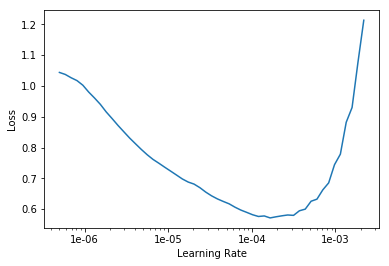

In [70]:
learn.lr_find(start_lr=1e-7, end_lr=1, num_it=100, stop_div=True)
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(10, max_lr=3e-5, callbacks=[SaveModelCallback(learn, every='improvement', mode='min',
                                                                  monitor='group_mean_log_mae',  name='mpnn1')])

epoch,train_loss,valid_loss,mean_absolute_error,group_mean_log_mae,time
0,0.068870,0.077403,0.058338,0.615427,12:58
1,0.082214,0.098659,0.080283,0.761751,13:00
2,0.064965,0.059671,0.046962,0.362164,13:14
3,0.052805,0.052565,0.040239,0.266511,13:18
4,0.045977,0.064451,0.050190,0.350891,13:17
5,0.037898,0.036675,0.026178,-0.136184,13:17
6,0.033944,0.036977,0.027067,-0.226302,13:18
7,0.030559,0.030446,0.020958,-0.426712,13:18
8,0.029049,0.028300,0.019257,-0.513017,13:18


Better model found at epoch 0 with group_mean_log_mae value: 0.615426778793335.
Better model found at epoch 2 with group_mean_log_mae value: 0.36216434836387634.
Better model found at epoch 3 with group_mean_log_mae value: 0.2665105164051056.
Better model found at epoch 5 with group_mean_log_mae value: -0.13618430495262146.
Better model found at epoch 6 with group_mean_log_mae value: -0.22630205750465393.
Better model found at epoch 7 with group_mean_log_mae value: -0.42671239376068115.
Better model found at epoch 8 with group_mean_log_mae value: -0.5130167603492737.


In [ ]:
learn.recorder.plot_losses(skip_start=100)